In [2]:
from pymongo import MongoClient
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ggplot import *

In [3]:
import pyspark
from pyspark.sql.types import *
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Build our Spark Session and Context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
sc = spark.sparkContext
spark, sc

(<pyspark.sql.session.SparkSession at 0x7f12c5db61d0>,
 <pyspark.context.SparkContext at 0x7f12fd208950>)

### load utility matrix

In [7]:
# load data frame from csv
data_df = pd.read_csv("model_df.csv", sep='\t')

# drop duplicates
data_df = data_df.drop_duplicates(subset=['route_id', 'user_id'])

y_data = data_df[['route_id', 'user_id','rating']]
x_data = data_df.drop(['rating', 'route_id', 'user_id', 'member_since', 'Unnamed: 0'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state=42)

In [8]:
# Convert to a Spark DataFrame
y_train_spark = spark.createDataFrame(y_train)
y_test_spark = spark.createDataFrame(y_test)

In [6]:
y_train_spark.show()

+--------+-------+------+
|route_id|user_id|rating|
+--------+-------+------+
|     370|    932|     3|
|     988|   1289|     2|
|    1519|    973|     3|
|    2014|   1669|     3|
|    1455|   1923|     4|
|     684|   1094|     2|
|    3609|    399|     2|
|    1497|   1647|     3|
|     982|    658|     3|
|    2091|   1660|     3|
|    3060|   1849|     3|
|    3245|   1017|     3|
|     798|   1148|     2|
|    1512|    917|     3|
|    1519|    641|     3|
|      26|   1134|     3|
|    1280|    472|     2|
|    2014|    614|     2|
|    1688|    218|     2|
|    1200|    925|     4|
+--------+-------+------+
only showing top 20 rows



In [5]:
path = 'alsmodel'

### save model

In [9]:
als_model = ALS(userCol='user_id',
                itemCol='route_id',
                ratingCol='rating',
                nonnegative=True,
                regParam=0.1,
                rank=10
               )
recommender = als_model.fit(y_train_spark)

In [12]:
recommender.save(path)

### load als model

In [9]:
recommender = ALSModel.load(path)

In [9]:
# Make predictions for the whole test set
predictions = recommender.transform(y_test_spark)

In [10]:
# Dump the predictions to Pandas DataFrames to make our final calculations easier
predictions_df = predictions.toPandas()

0.727068214556


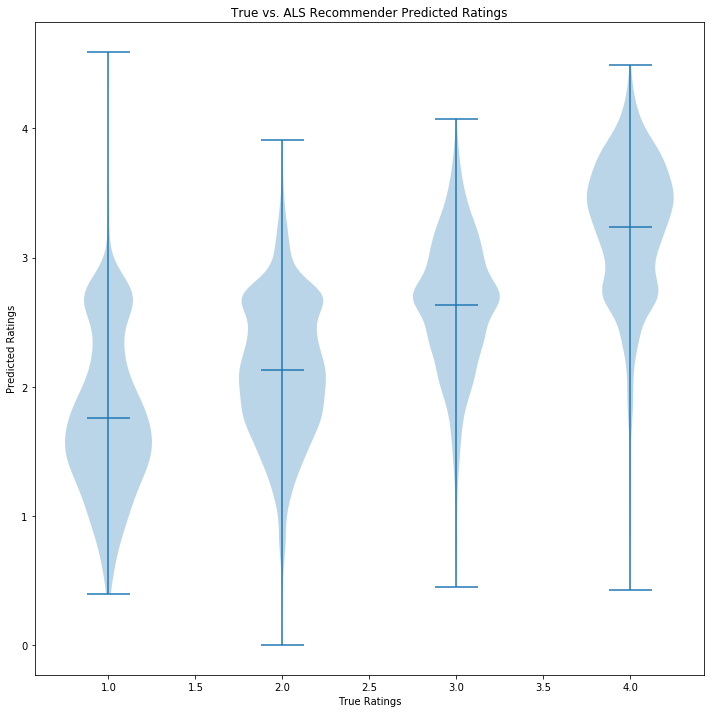

In [49]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

fig.savefig('../data/images/violin_als.jpg')

### grab gradient boosting pickle model

In [93]:
from sklearn.externals import joblib
gb = joblib.load('../pickle/gb_model.pkl') 
gb_predict = gb.predict(X_test)

In [94]:
feat_imp = gb.feature_importances_
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb.feature_importances_},
                           index=X_test.columns)

In [23]:
feat_scores_lim = feat_scores.sort_values(by='Fraction of Samples Affected', ascending=False).head(10)

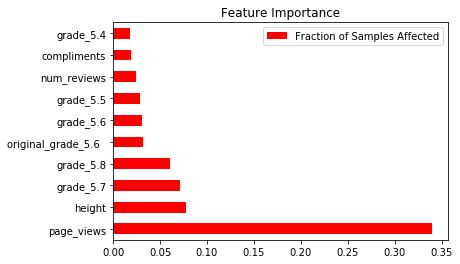

In [24]:
feat_scores_lim.plot(kind='barh', color='red', title= 'Feature Importance')
plt.savefig('../data/images/gb_features.jpg')

### fill nulls with gb model prediction

In [42]:
predictions_df = predictions.toPandas()

In [43]:
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]

In [44]:
predictions_df.ix[null_ind, 'prediction'] = gb_predict[null_ind]

In [45]:
predictions_df.head(18)

,route_id,user_id,rating,prediction
0,1644,471,4,3.682827
1,1348,471,2,3.420109
2,2332,471,4,1.812155
3,2766,471,2,2.723631
4,1966,833,3,2.673659
5,684,833,3,2.665126
6,1834,1238,3,3.883815
7,1498,1238,2,3.117351
8,478,1238,2,3.838965
9,414,1591,1,2.123469


0.727068214556


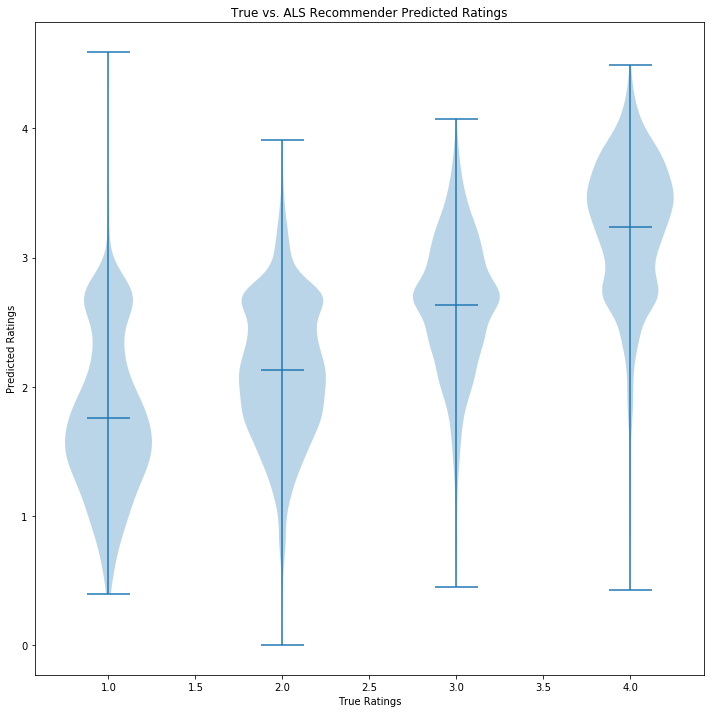

In [46]:
# Fill any missing values with the mean rating
# There are multiple things you could fill with, this is just one example
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [47]:
fig.savefig('../data/images/violin_ensemble1.jpg')

### try weighted

In [50]:
predictions_df = predictions.toPandas()
predictions_df = predictions.toPandas().fillna(y_train['rating'].mean())

In [51]:
predictions_df['weighted'] = (0.8 * predictions_df['prediction']) + (0.2 * pd.DataFrame(gb_predict)[0])

In [52]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2

In [53]:
# Calculate RMSE
np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.71354416368689366

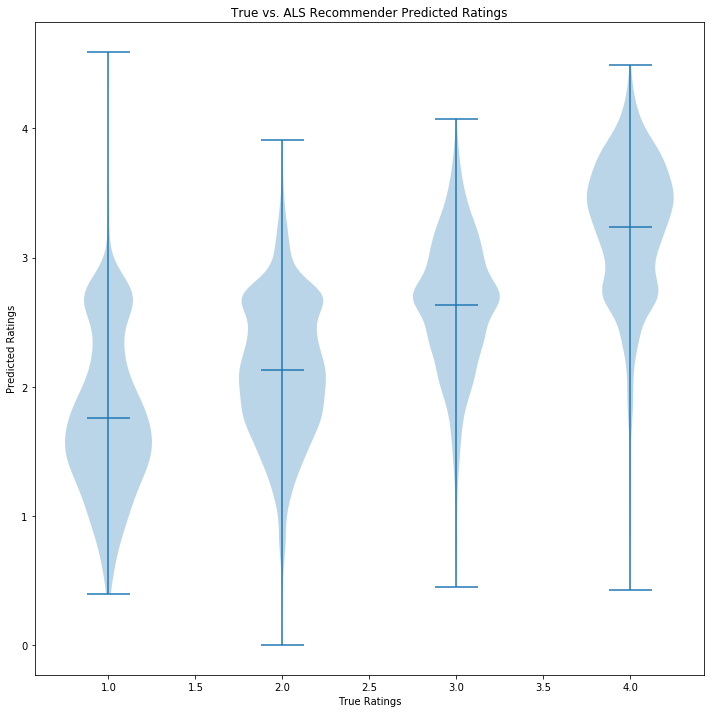

In [54]:
fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [55]:
fig.savefig('../data/images/violin_ensemble2.jpg')

In [56]:
predictions_df[predictions_df['user_id'] == 560]

,route_id,user_id,rating,prediction,weighted,squared_error
2343,3128,560,3,3.117631,3.120808,0.014595
2344,956,560,4,3.599636,3.330639,0.448044
2345,3351,560,2,2.655662,2.563832,0.317907
2346,199,560,3,2.617110,2.691866,0.094947
2347,2417,560,4,3.622202,3.410295,0.347752


### reweight based on num of reviews

In [91]:
normalized_rating_count = X_test['num_reviews'] / float(X_test['num_reviews'].max())

rmse_list = []
for j in np.linspace(0.0, 1.0, num=100):
    predictions_df['weighted2'] = predictions_df['weighted'] + (j * normalized_rating_count).tolist()
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
    # Calculate RMSE
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)
    print "rmse: {}, weight: {}".format(rmse, j)

rmse: 0.713544163687, weight: 0.0
rmse: 0.713438726837, weight: 0.010101010101
rmse: 0.713340247456, weight: 0.020202020202
rmse: 0.713248728427, weight: 0.030303030303
rmse: 0.713164172428, weight: 0.040404040404
rmse: 0.713086581938, weight: 0.0505050505051
rmse: 0.713015959229, weight: 0.0606060606061
rmse: 0.712952306373, weight: 0.0707070707071
rmse: 0.712895625237, weight: 0.0808080808081
rmse: 0.712845917483, weight: 0.0909090909091
rmse: 0.712803184571, weight: 0.10101010101
rmse: 0.712767427754, weight: 0.111111111111
rmse: 0.712738648084, weight: 0.121212121212
rmse: 0.712716846404, weight: 0.131313131313
rmse: 0.712702023356, weight: 0.141414141414
rmse: 0.712694179375, weight: 0.151515151515
rmse: 0.712693314691, weight: 0.161616161616
rmse: 0.71269942933, weight: 0.171717171717
rmse: 0.712712523112, weight: 0.181818181818
rmse: 0.712732595652, weight: 0.191919191919
rmse: 0.712759646362, weight: 0.20202020202
rmse: 0.712793674445, weight: 0.212121212121
rmse: 0.71283467890

In [73]:
min(rmse_list)

0.71269331469090236

In [75]:
min_rmse_ind = rmse_list.index(min(rmse_list))

In [76]:
weight = np.linspace(0.0, 1.0, num=100)[min_rmse_ind]

In [77]:
weight

0.16161616161616163

In [78]:
predictions_df['weighted2'] = predictions_df['weighted'] + (weight * normalized_rating_count).tolist()
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
print "RMSE:", np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

RMSE: 0.712693314691


### find user predictions

In [79]:
data = pd.DataFrame(columns=['route_id', 'user_id'])
data['user_id'] = (0 * y_data['route_id']) + 560 
data['route_id'] = y_data['route_id']
one_row_spark_df = spark.createDataFrame(data)
# Get the recommender's prediction
recs = recommender.transform(one_row_spark_df)
recs.show()

+--------+-------+----------+
|route_id|user_id|prediction|
+--------+-------+----------+
|     148|    560| 0.7641963|
|     463|    560| 0.8248104|
|     463|    560| 0.8248104|
|     463|    560| 0.8248104|
|     463|    560| 0.8248104|
|     463|    560| 0.8248104|
|     463|    560| 0.8248104|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
|     471|    560| 1.1687702|
+--------+-------+----------+
only showing top 20 rows



In [80]:
recs_df = recs.toPandas().drop_duplicates(subset='route_id')
recs_df.sort_values('prediction', ascending=False).head(6)

,route_id,user_id,prediction
3586,3370,560,4.404656
15816,1022,560,4.404656
20525,2539,560,4.404656
22188,595,560,4.404656
11072,1979,560,4.404656
9294,2651,560,4.011049


### Try reweighting

In [81]:
df = data_df.drop_duplicates(subset=['route_id'])

In [82]:
df = df.reset_index().drop('index', axis=1)

In [83]:
df['route_id'].tolist() == recs_df['route_id'].tolist()

False

In [84]:
recs_df = recs_df.reset_index().drop('index', axis=1)

In [85]:
normalized_rating_count = df['num_reviews'] / float(df['num_reviews'].max())

In [86]:
recs_df['new_pred'] = recs_df['prediction'] + (normalized_rating_count * 0.5)

In [87]:
recs_df.sort_values('new_pred', ascending=False).head(6)

,route_id,user_id,prediction,new_pred
1398,1979,560,4.404656,4.466748
1964,1022,560,4.404656,4.419362
2505,2539,560,4.404656,4.417728
2743,595,560,4.404656,4.406290
421,3370,560,4.404656,4.406290
1133,2651,560,4.011049,4.012683


### Add item-by-item matrix

In [11]:
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

# load data frame from csv
routes_df = pd.read_csv("routes_df.csv", sep='\t').drop('Unnamed: 0', axis=1)
routes_df.head()

,id,Aid,Alpine,Boulder,Ice,Mixed,Sport,TR,Trad,height,...,area_World WallaAreas,area_Write-off RockaAreas,area_Wu Wei WallaAreas,area_Wu-Tang WallaAreas,area_XY Crag (Chromosome Cracks)aAreas,area_Zappa WallaAreas,area_Zeke's Trail BouldersaAreas,area_Zeke's WallaAreas,area_Zig Zag WallaAreas,num_reviews
0,0,0,0,0,0,0,0,0,1,41.0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,1,41.0,...,0,0,0,0,0,0,0,0,0,1
2,2,0,0,0,0,0,0,1,1,35.0,...,0,0,0,0,0,0,0,0,0,4
3,3,0,0,0,0,0,0,1,1,85.0,...,0,0,0,0,0,0,0,0,0,4
4,4,0,0,0,0,0,0,1,1,30.0,...,0,0,0,0,0,0,0,0,0,4


In [12]:
routes_id = routes_df['id']
routes_df = routes_df.drop('id', axis=1)

In [13]:
items_mat = np.array(list(routes_df.values)).astype(float)

In [54]:
items_mat_norm = normalize(items_mat)
cos_sim = 1-pairwise_distances(items_mat, metric="cosine")

### What is the RMSE for item-by-item?

In [84]:
item_by_item_pred = [] 
n = 5
for _id in y_test['route_id']:
    # find the similar routes
    index = routes_id[routes_id == _id].index.tolist()[0]
    arr = cos_sim[index]
    similar_routes = np.asarray(routes_id)[arr.argsort()[-(n+1):][::-1][1:]]
    # average the five routes together to get rating
    pred = y_train[y_train['route_id'].isin(similar_routes)]['rating']
    mean_rating = pred.mean()
    item_by_item_pred.append(mean_rating) 

In [85]:
predictions_df['item_by_item_pred'] = pd.Series(item_by_item_pred)
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['item_by_item_pred'])**2
np.sqrt(sum(predictions_df['rating'] - predictions_df['squared_error']) / len(predictions_df))

1.3966725260592467

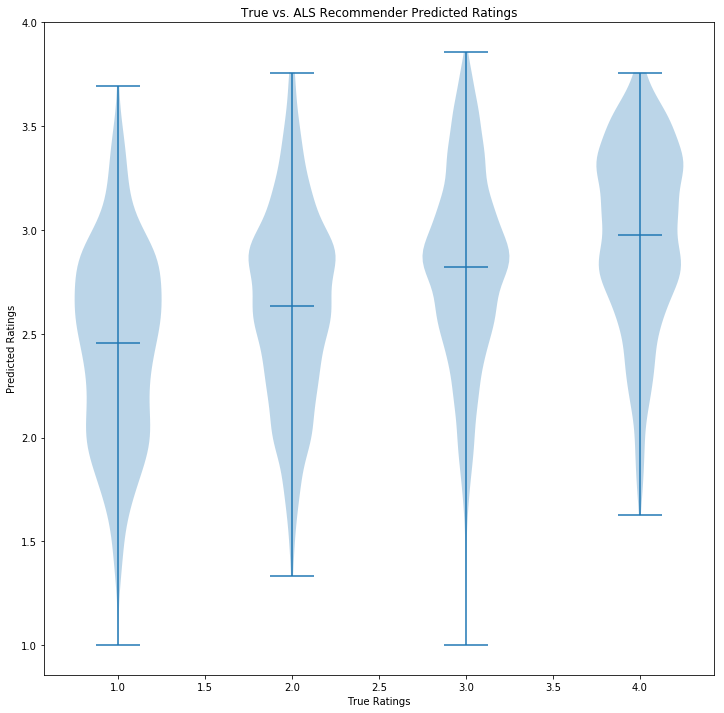

In [86]:
# Create array of predictions for violinplot
data = [predictions_df['item_by_item_pred'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [87]:
# fill nulls with item_by item value
predictions_df = predictions.toPandas()
null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]
predictions_df.ix[null_ind, 'prediction'] = np.array(item_by_item_pred)[null_ind]

0.720091817062


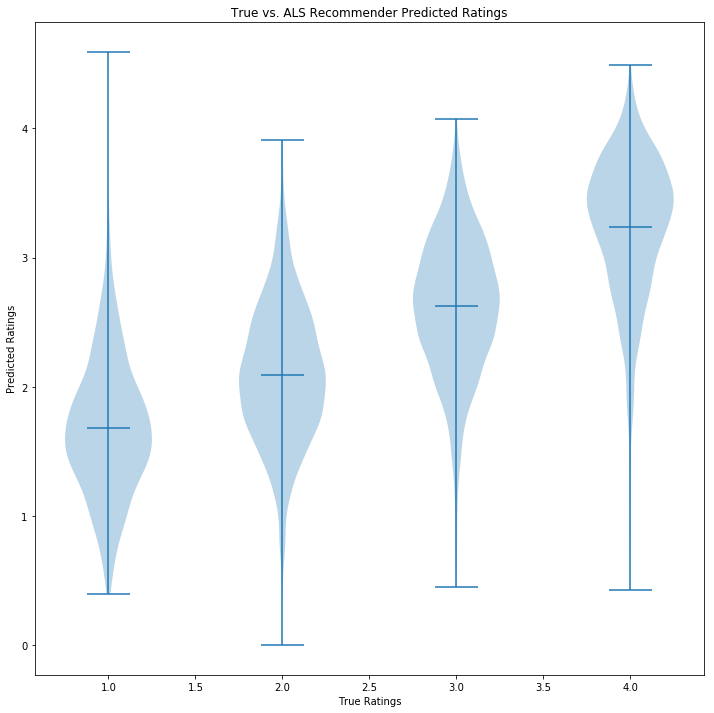

In [88]:
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['prediction'])**2

# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

# Create array of predictions for violinplot
data = [predictions_df['prediction'][predictions_df['rating'] == rating] for rating in range(1, 5)]

fig, ax = plt.subplots(1, figsize=(12,12))
ax.violinplot(data, range(1,5), showmeans=True)
ax.set_xlabel('True Ratings')
ax.set_ylabel('Predicted Ratings')
ax.set_title('True vs. ALS Recommender Predicted Ratings')
plt.show()

In [111]:
fig.savefig('../data/images/violin_item_by_item_ensemble.jpg')

### add weighted values to item-by-item matrix

In [89]:
normalized_rating_count = X_test['num_reviews'] / float(X_test['num_reviews'].max())

In [90]:
rmse_list = []
for c in np.linspace(100.0,110.0, 100):
    alpha = np.array((2.0 / (1 + np.exp(-c * normalized_rating_count))) - 1)
    predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2
    # Calculate RMSE
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)

In [91]:
c = np.linspace(100.0,110.0, 100)[rmse_list.index(min(rmse_list))]

In [92]:
alpha = np.array((2.0 / (1 + np.exp(-c * normalized_rating_count))) - 1)
predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted'])**2
# Calculate RMSE
print np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))

0.702557129615


### let's try all three methods

In [96]:
# fill nulls with item_by item value
rmse_list = []
for beta in np.linspace(0.0, 1.0, 100):
    predictions_df = predictions.toPandas()
    null_ind = pd.isnull(predictions_df).any(1).nonzero()[0]
    predictions_df.ix[null_ind, 'prediction'] = np.array(item_by_item_pred)[null_ind]
    predictions_df['weighted'] = alpha *  predictions_df['prediction'] + (1 - alpha) * item_by_item_pred
    predictions_df['weighted2'] = (beta * predictions_df['weighted']) + ((1 - beta) * pd.DataFrame(gb_predict)[0])
    predictions_df['squared_error'] = (predictions_df['rating'] - predictions_df['weighted2'])**2
    rmse = np.sqrt(sum(predictions_df['squared_error']) / len(predictions_df))
    rmse_list.append(rmse)


In [97]:
min(rmse_list)

0.66790338120078507